###  Created by Luis Alejandro (alejand@umich.edu)

## MLP-FSPP-RFE
Performs a recursive feature elimination (RFE) approach using feature sensitivity to posterior probability (FSPP) for MLP according to:

https://ieeexplore.ieee.org/abstract/document/5282531

In [1]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.feature_selection.fspp import get_fspp

In [2]:
# Load dataset
dataset = datasets.load_breast_cancer()
print(dataset.feature_names, end="\n")
print(dataset.target_names)
predictors = dataset.data
responses = dataset.target

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


In [3]:
# Splits into training/test sets
X,X_holdout,y,y_holdout = train_test_split(predictors,responses,test_size = 0.3,random_state = 0)

In [4]:
# Defines model
regularization = 0
sc = StandardScaler()
clf = MLPClassifier(hidden_layer_sizes=(30), alpha=regularization,)
estimators = [('normalizer', sc), ('classifier', clf)]
pipe = Pipeline(estimators)

In [5]:
# Applies RFE
step = 5
d = X.shape[1]
current_features = set(range(d))
deleted_features = list()
performance = list()
while len(current_features) > 0:
    # train model
    features = [feature for feature in current_features]
    results = cross_validate(pipe,X[:,features],y,cv = 5,scoring = ['accuracy'], n_jobs=-1,
                             return_estimator=True, return_train_score=True)
    best_pipe = results['estimator'][results['test_accuracy'].argmin()]
    y_pred = best_pipe.predict(X_holdout[:,features])
    train_err =  1 - results['train_accuracy'].mean()
    val_err = 1 - results['test_accuracy'].mean()
    test_err = 1 - accuracy_score(y_holdout, y_pred)
    performance.append((len(current_features),train_err,val_err,test_err))
    # compute rank
    relevance = get_fspp(best_pipe,X[:,features])
    # delete features
    rank = relevance.argsort()
    for i in rank[:step]:
        current_features.discard(features[i])
        deleted_features.append(features[i])
    print('Iteration -',
          'features: %d' % (len(current_features) + min(len(rank),step)),
          ', train_err %.2f' % train_err,
          ', val_err %.2f' % val_err,
          ', test_err: %.2f' % test_err,
          ', deleted:', [features[i] for i in rank[:step]])

Iteration - features: 30 , train_err 0.01 , val_err 0.03 , test_err: 0.02 , deleted: [16, 25, 28, 27, 13]
Iteration - features: 25 , train_err 0.01 , val_err 0.02 , test_err: 0.03 , deleted: [14, 15, 17, 18, 9]
Iteration - features: 20 , train_err 0.01 , val_err 0.03 , test_err: 0.03 , deleted: [5, 4, 11, 3, 6]
Iteration - features: 15 , train_err 0.01 , val_err 0.02 , test_err: 0.02 , deleted: [29, 1, 22, 19, 10]
Iteration - features: 10 , train_err 0.02 , val_err 0.03 , test_err: 0.04 , deleted: [8, 23, 26, 7, 0]
Iteration - features: 5 , train_err 0.03 , val_err 0.03 , test_err: 0.02 , deleted: [21, 12, 24, 2, 20]


[16, 25, 28, 27, 13, 14, 15, 17, 18, 9, 5, 4, 11, 3, 6, 29, 1, 22, 19, 10, 8, 23, 26, 7, 0, 21, 12, 24, 2, 20]
set()


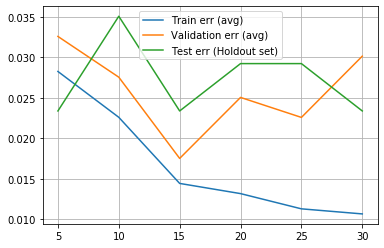

In [6]:
# Plots results
print(deleted_features)
print(current_features)

features = [results[0] for results in performance]
train_err = [results[1] for results in performance]
val_err = [results[2] for results in performance]
test_err = [results[3] for results in performance]

plt.plot(features,train_err,label='Train err (avg)')
plt.plot(features,val_err, label='Validation err (avg)')
plt.plot(features,test_err,label='Test err (Holdout set)')
plt.legend()
plt.grid()